In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SOZ_DIR = "../../Data/seizure_onset_zones/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    196,  # not enough time before first seizure
    204,  # not enough time before first seizure
    169,  # not enough time after the last seizure
    173,
    150,  # not enough time before first seizure
    207,  # not enough time before first seizure
    223,
    196,  # not enough time before first seizure
    204,  # not enough time before first seizure
    177,
    185,
    189,  # not enough time before first seizure
    205,  # not enough time before first seizure
    166,
    170,  # not enough time before first seizure
    174,  # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())
# Initialize a dataframe with hup_id, dataset_name, fs
patients_df = pd.DataFrame(columns=["hup_id", "dataset_name", "fs"])
for patient_hup_id in completed_hup_ids:
    dataset_name = f"HUP{patient_hup_id}_phaseII"
    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    fs = int(dataset.get_time_series_details(channel_labels_to_download[0]).sample_rate)
    # Construct a row and add it to the dataframe
    row_df = pd.DataFrame(
        [{"hup_id": patient_hup_id, "dataset_name": dataset_name, "fs": fs}]
    )
    patients_df = pd.concat([patients_df, row_df], ignore_index=True)
# Sort the dataframe by hup_id
patients_df = patients_df.sort_values(by="hup_id")
# reset the index
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,dataset_name,fs
0,138,HUP138_phaseII,1024
1,142,HUP142_phaseII,512
2,145,HUP145_phaseII,512
3,150,HUP150_phaseII,512
4,151,HUP151_phaseII,512
5,160,HUP160_phaseII,1024
6,166,HUP166_phaseII,1024
7,169,HUP169_phaseII,512
8,170,HUP170_phaseII,512
9,172,HUP172_phaseII,512


In [5]:
thresholds = [
    4.6,
    4,
    4,
    4.3,
    4,
    5.5,
    4.1,
    4,
    3.8,
    4,
    3.8,
    4.5,
    4,
    4,
    4,
    4,
    4,
    4,
    4,
    3.7,
    4,
    4,
    4,
    5,
    4,
    4,
]
thresholds = np.exp(thresholds)
thresholds, len(thresholds)

(array([ 99.48431564,  54.59815003,  54.59815003,  73.6997937 ,
         54.59815003, 244.69193226,  60.3402876 ,  54.59815003,
         44.70118449,  54.59815003,  44.70118449,  90.0171313 ,
         54.59815003,  54.59815003,  54.59815003,  54.59815003,
         54.59815003,  54.59815003,  54.59815003,  40.44730436,
         54.59815003,  54.59815003,  54.59815003, 148.4131591 ,
         54.59815003,  54.59815003]),
 26)

In [6]:
def format_channels(channel_array):
    formatted_array = []
    for label in channel_array:
        if label == "PZ":
            formatted_array.append(label)
            continue

        # Splitting string into two parts: prefix (letters) and number
        prefix, number = (
            label[: -len([ch for ch in label if ch.isdigit()])],
            label[-len([ch for ch in label if ch.isdigit()]) :],
        )

        # Formatting the number to have two digits
        formatted_number = f"{int(number):02}"

        # Appending prefix and formatted number
        formatted_label = prefix + formatted_number
        formatted_array.append(formatted_label)

    return np.array(formatted_array)

In [7]:
# def create_pwd_file(username, password, fname=None):
#     if fname is None:
#         fname = "{}_ieeglogin.bin".format(username[:3])
#     with open(fname, "wb") as f:
#         f.write(password.encode())
#     print("-- -- IEEG password file saved -- --")


# create_pwd_file("dma", "mycqEv-pevfo4-roqfan")
# print("Using Devin session")
# with open("dma_ieeglogin.bin", "r") as f:
#     session = Session("dma", f.read())
print("Using Carlos session")
with open("agu_ieeglogin.bin", "r") as f:
    session = Session("aguilac", f.read())

Using Carlos session


In [8]:
all_spikes_dfs = []
all_fs = []
for patient_index, row in patients_df.iterrows():
    patient_hup_id = row["hup_id"]
    fs = row["fs"]
    all_fs.append(fs)
    dataset_name = row["dataset_name"]

    print(f"Processing HUP {patient_hup_id} with fs {fs}")

    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    ###############################
    # Construct spike_files_df
    ###############################

    # Initialize an empty list to hold the data
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(SPIKES_OUTPUT_DIR):
        # Check if the file ends with .npy
        if filename.endswith(".npy"):
            # Use regular expression to match the pattern and extract desired numbers
            match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

            if match:
                current_patient_hup_id = int(match.group(1))
                if current_patient_hup_id != patient_hup_id:
                    continue
                interval_index = int(match.group(2))

                # Append the data to the list
                data.append(
                    {
                        "filename": filename,
                        "interval_index": interval_index,
                    }
                )

    # Convert the list of dictionaries to a pandas DataFrame
    spike_files_df = pd.DataFrame(data)
    # Sort the DataFrame by the interval index
    spike_files_df = spike_files_df.sort_values(by="interval_index")
    # Reset the index
    spike_files_df = spike_files_df.reset_index(drop=True)
    # Add a new column called "start_sample_index"
    spike_files_df["start_sample_index"] = (
        spike_files_df["interval_index"] * fs * 60 * 2
    )

    ###############################
    # Construct all_spikes_df
    ###############################
    # Initialize an empty list to store individual DataFrames
    dfs = []

    for index, row in spike_files_df.iterrows():
        filename = row["filename"]
        start_sample_index = row["start_sample_index"]

        # Load the data
        spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

        # Adjust the start_sample_index
        spike_data[:, 0] += start_sample_index

        # Convert the modified spike_data to a DataFrame and append to the dfs list
        dfs.append(
            pd.DataFrame(
                spike_data,
                columns=[
                    "peak_index",
                    "channel_index",
                    "peak",
                    "left_point",
                    "right_point",
                    "slow_end",
                    "slow_max",
                    "rise_amp",
                    "decay_amp",
                    "slow_width",
                    "slow_amp",
                    "rise_slope",
                    "decay_slope",
                    "average_amp",
                    "linelen",
                ],
            )
        )

    # Concatenate all the individual DataFrames into a single DataFrame
    all_spikes_df = pd.concat(dfs, ignore_index=True)
    # Drop any rows with any NaN values
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)
    # Make peak_index and channel_index integers
    all_spikes_df["peak_index"] = all_spikes_df["peak_index"].astype(int)
    # Add a column called peak_time_microseconds
    all_spikes_df["peak_time_microseconds"] = (
        all_spikes_df["peak_index"] / fs * 1e6
    ).astype(int)
    all_spikes_df["channel_index"] = all_spikes_df["channel_index"].astype(int)
    # Add a column called channel_label that indexes into channel_labels_to_download using channel_index
    all_spikes_df["channel_label"] = format_channels(channel_labels_to_download)[
        all_spikes_df["channel_index"].values
    ]
    # Drop the column peak	left_point	right_point	slow_end
    all_spikes_df = all_spikes_df.drop(
        columns=["peak", "left_point", "right_point", "slow_end"]
    )
    # Reset the index
    all_spikes_df = all_spikes_df.reset_index(drop=True)

    ###############################
    # ISI
    ###############################
    # Calculate the inter-spike interval
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

    # Drop the first row and reset index
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)

    # Convert the inter_spike_interval_samples column to integer
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
        "inter_spike_interval_samples"
    ].astype(int)

    ###############################
    # sequence_index
    ###############################
    print(f"this is for patient {patient_hup_id} with index {patient_index}")
    # Check for sequence change based on sequence_index or inter_spike_interval_samples
    change_mask = (
        all_spikes_df["inter_spike_interval_samples"] > thresholds[patient_index]
    )

    # Create the sequence_index_mask
    all_spikes_df["sequence_index"] = change_mask.astype(int).cumsum()

    ###############################
    # is_leader
    ###############################
    # Adding is_leader column
    all_spikes_df["is_leader"] = ~all_spikes_df["sequence_index"].duplicated(
        keep="first"
    )

    ###############################
    # is_soz
    ###############################
    # Add a column called is_soz and set it to true if the channel_label is in the soz list
    soz_channels = np.load(os.path.join(SOZ_DIR, f"HUP_{patient_hup_id}.npy"))
    all_spikes_df["is_soz"] = all_spikes_df["channel_label"].isin(soz_channels)

    ###############################
    # Reorganize columns to the order of peak_index	channel_index inter_spike_interval_samples	sequence_index	is_leader slow_max	rise_amp	decay_amp	slow_width	slow_amp	rise_slope	decay_slope	average_amp	linelen
    ###############################
    all_spikes_df = all_spikes_df[
        [
            "peak_index",
            "peak_time_microseconds",
            "channel_index",
            "channel_label",
            "is_soz",
            "inter_spike_interval_samples",
            "sequence_index",
            "is_leader",
            "slow_max",
            "rise_amp",
            "decay_amp",
            "slow_width",
            "slow_amp",
            "rise_slope",
            "decay_slope",
            "average_amp",
            "linelen",
        ]
    ]

    ###############################
    # Edit column names
    ###############################
    # Add "morphology_" prefix to slow_max	rise_amp	decay_amp	slow_width	slow_amp	rise_slope	decay_slope	average_amp	linelen

    all_spikes_df = all_spikes_df.rename(
        columns={
            "peak_index": "peak_index_samples",
            "slow_max": "morphology_slow_max",
            "rise_amp": "morphology_rise_amp",
            "decay_amp": "morphology_decay_amp",
            "slow_width": "morphology_slow_width",
            "slow_amp": "morphology_slow_amp",
            "rise_slope": "morphology_rise_slope",
            "decay_slope": "morphology_decay_slope",
            "average_amp": "morphology_average_amp",
            "linelen": "morphology_linelen",
        }
    )

    all_spikes_dfs.append(all_spikes_df)
    # Save the DataFrame to an csv file
    all_spikes_df.to_csv(f"../../Public/spikes/HUP_{patient_hup_id}.csv", index=False)

Processing HUP 138 with fs 1024
this is for patient 138 with index 0
Processing HUP 142 with fs 512
this is for patient 142 with index 1
Processing HUP 145 with fs 512
this is for patient 145 with index 2
Processing HUP 150 with fs 512
this is for patient 150 with index 3
Processing HUP 151 with fs 512
this is for patient 151 with index 4
Processing HUP 160 with fs 1024
this is for patient 160 with index 5
Processing HUP 166 with fs 1024
this is for patient 166 with index 6
Processing HUP 169 with fs 512
this is for patient 169 with index 7
Processing HUP 170 with fs 512
this is for patient 170 with index 8
Processing HUP 172 with fs 512
this is for patient 172 with index 9
Processing HUP 173 with fs 256
this is for patient 173 with index 10
Processing HUP 174 with fs 512
this is for patient 174 with index 11
Processing HUP 177 with fs 512
this is for patient 177 with index 12
Processing HUP 180 with fs 512
this is for patient 180 with index 13
Processing HUP 184 with fs 512
this is fo

In [9]:
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index,is_leader,morphology_slow_max,morphology_rise_amp,morphology_decay_amp,morphology_slow_width,morphology_slow_amp,morphology_rise_slope,morphology_decay_slope,morphology_average_amp,morphology_linelen
0,47346,46236328,151,RB02,False,29491,1,True,564.090690,287.873064,502.880077,234.0,564.090690,-6.694722,16.221938,539.313102,1858.247795
1,94907,92682617,35,LF02,False,47561,2,True,146.706075,286.049471,337.107399,99.0,146.706075,-4.767491,8.427685,454.603171,850.804317
2,312341,305020507,24,LC03,True,217434,3,True,187.900010,238.559111,122.480088,74.0,187.900010,-8.519968,9.421545,299.799155,609.901508
3,312343,305022460,14,LB04,False,2,3,False,223.596496,241.248965,448.439417,110.0,223.596496,5.610441,-26.378789,465.468673,1022.691209
4,312346,305025390,1,LA02,False,3,3,False,60.860253,139.959601,228.392380,117.0,60.860253,4.373738,-6.010326,254.155791,452.849615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339932,498118076,486443433593,67,LQ02,False,1711,106340,True,489.765539,870.013776,644.590287,51.0,489.765539,-33.462068,14.990472,1192.308920,5680.139595
339933,498120214,486445521484,67,LQ02,False,2138,106341,True,384.870761,1062.828490,881.636103,51.0,384.870761,44.284520,-20.037184,1503.646542,5798.458802
339934,498128744,486453851562,67,LQ02,False,8530,106342,True,786.426710,1066.461195,1164.109649,51.0,786.426710,42.658448,-27.072317,1648.516019,5989.266665
339935,498128995,486454096679,85,LS08,False,251,106343,True,189.959907,595.676016,301.073796,68.0,189.959907,-31.351369,6.842586,746.212913,1153.430960


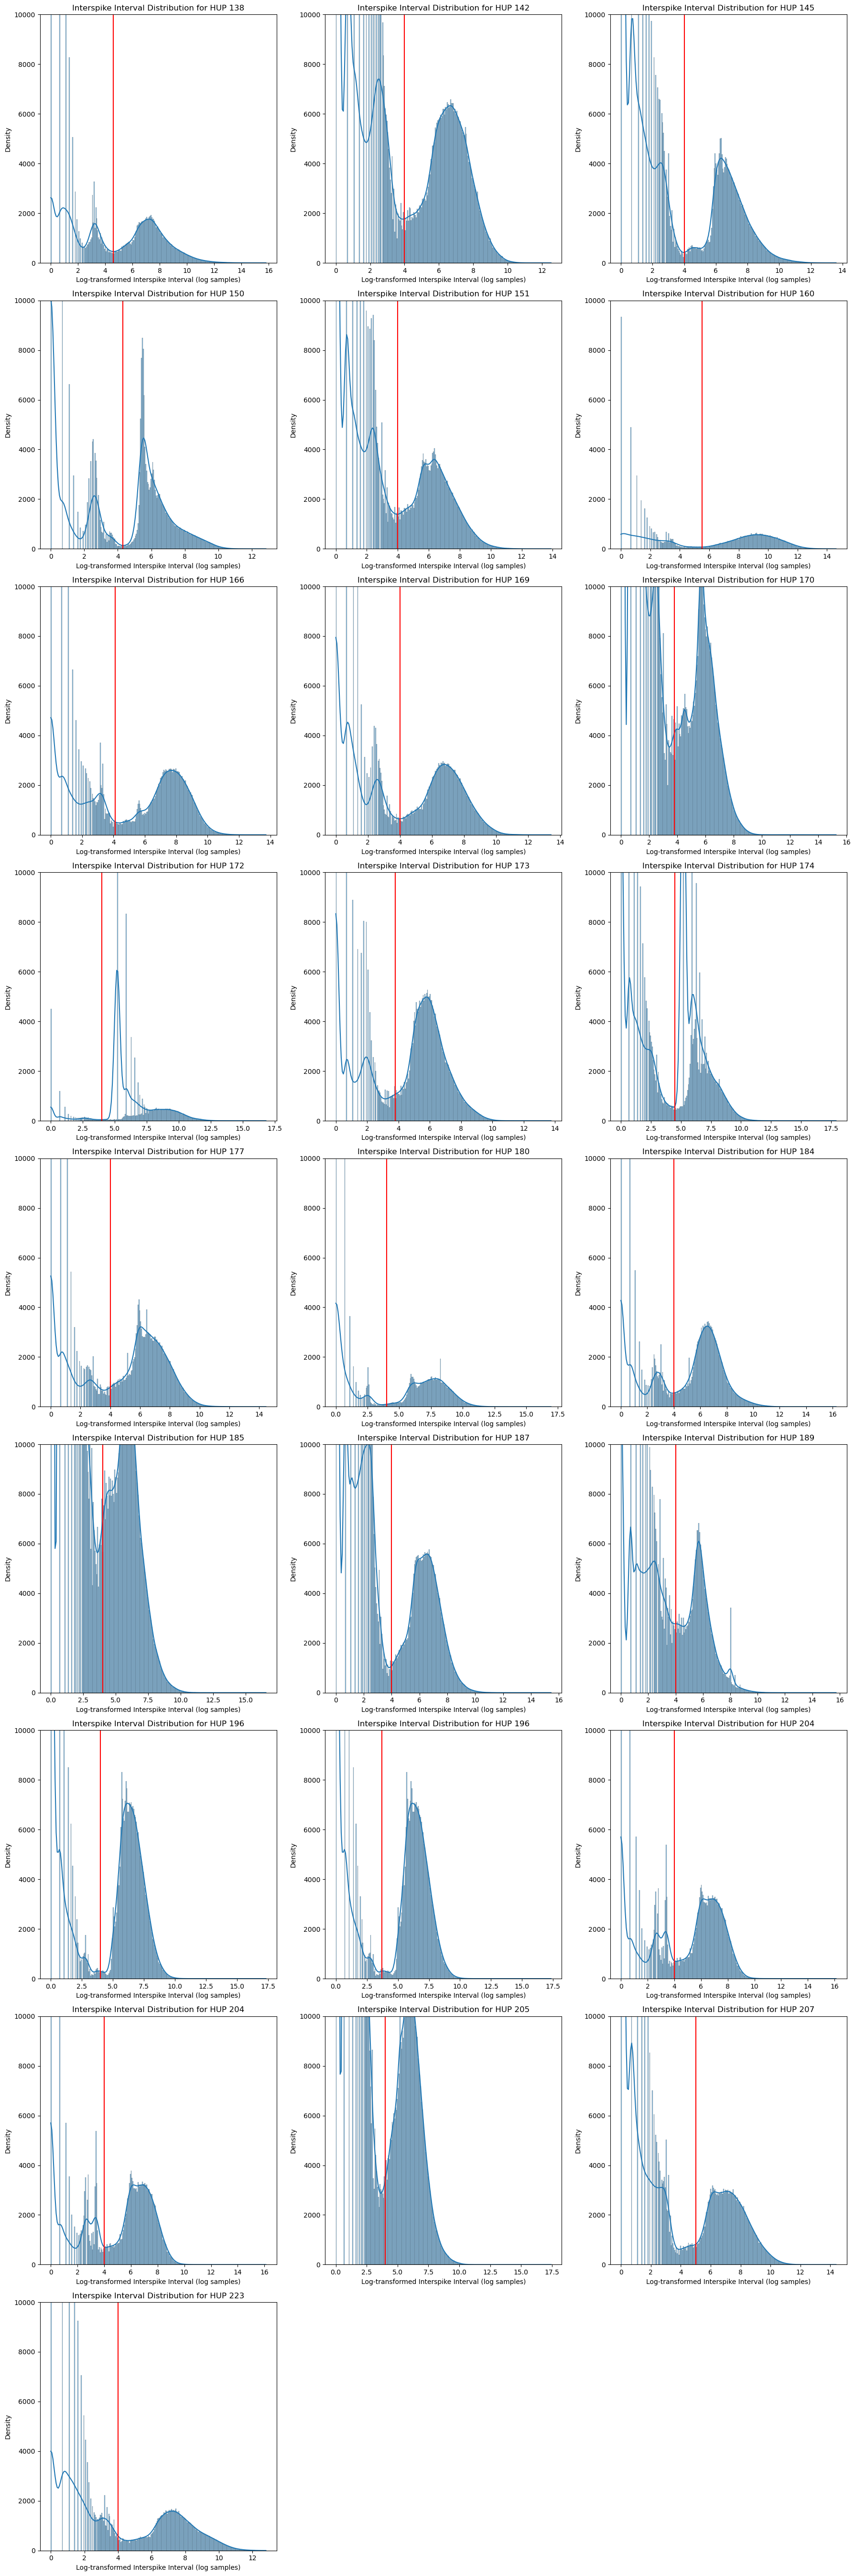

In [10]:
# Determine number of rows
num_plots = len(completed_hup_ids)
num_columns = 3
num_rows = (num_plots + 2) // num_columns  # ceil division

# Create a main figure and axes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

# If there's only one row, axes is 1D and we should reshape it
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (hup_id, all_spikes_df) in enumerate(zip(completed_hup_ids, all_spikes_dfs)):
    # Find the row in patients_df that corresponds to the current hup_id
    patient_row = patients_df[patients_df["hup_id"] == hup_id]

    # Visualize with log transformation (excluding zeros to avoid -inf)
    log_data = np.log(
        all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
            "inter_spike_interval_samples"
        ]
    )

    ax = axes[idx // num_columns, idx % num_columns]
    sns.histplot(log_data, kde=True, bins=250, ax=ax)
    # plot a vertical line at the threshold
    ax.axvline(np.log(thresholds[idx]), color="red", label="Threshold")
    ax.set_title(f"Interspike Interval Distribution for HUP {hup_id}")
    ax.set_xlabel("Log-transformed Interspike Interval (log samples)")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 10000)

# Remove any unused subplots
for idx in range(num_plots, num_rows * num_columns):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()